In [1]:
import sortednp as snp
import importlib
from sortedcontainers import SortedSet
import numpy as np
from numpy import array
from bitarray import bitarray
import timeit
import realkd.search
from realkd.datasets import noisy_parity
from time import sleep

In [2]:
def original_greedy_simplification(self, intent, extent):
    to_cover = SortedSet([i for i in range(self.m) if i not in extent])
    available = list(range(len(intent)))
    covering = [SortedSet([i for i in range(self.m) if i not in self.extents[j]]) for j in intent]
    result = []
    while to_cover:
        j = max(available, key=lambda i: len(covering[i]))
        result += [intent[j]]
        available.remove(j)
        to_cover -= covering[j]
        for l in available:
            covering[l] -= covering[j]

    return result

def patched_greedy_simplification(self, intent, extent):
    to_cover = SortedSet(range(self.m)).difference(SortedSet(extent))
    available = list(range(len(intent)))
    covering = [SortedSet(range(self.m)).difference(SortedSet(self.extents[j])) for j in intent]
    result = []
    while to_cover:
        j = max(available, key=lambda i: len(covering[i]))
        result += [intent[j]]
        available.remove(j)
        to_cover -= covering[j]
        for l in available:
            covering[l] -= covering[j]

    return result

def get_bit_array_from_indexes(indexes, length):
    result = bitarray(length)
    result.setall(0)
    for index in indexes:
        result[index] = 1
    return result

def original___init__(self, attributes, objects, sort_attributes=True):
    self.attributes = attributes
    self.objects = objects
    self.n = len(attributes)
    self.m = len(objects)

    # for now we materialise the whole binary relation; in the future can be on demand
    # self.extents = [SortedSet([i for i in range(self.m) if attributes[j](objects[i])]) for j in range(self.n)]
    self.extents = [array([i for i in range(self.m) if attributes[j](objects[i])], dtype='int64') for j in range(self.n)]
    self.bit_extents = [bitarray([True if attributes[j](objects[i]) else False for i in range(self.m)]) for j in range(self.n)]

    # sort attribute in ascending order of extent size
    if sort_attributes:
        attribute_order = list(sorted(range(self.n), key=lambda i: len(self.extents[i])))
        self.attributes = [self.attributes[i] for i in attribute_order]
        self.extents = [self.extents[i] for i in attribute_order]
        self.bit_extents = [self.bit_extents[i] for i in attribute_order]

    # switches
    self.crit_propagation = True

    # stats
    self.popped = 0
    self.created = 0
    self.avg_created_length = 0
    self.rec_crit_hits = 0
    self.crit_hits = 0
    self.del_bnd_hits = 0
    self.clo_hits = 0
    self.non_lexmin_hits = 0
    self.bnd_post_children_hits = 0
    self.bnd_immediate_hits = 0

def patched___init__(self, attributes, objects, sort_attributes=True):
    self.attributes = attributes
    self.objects = objects
    self.n = len(attributes)
    self.m = len(objects)

    # for now we materialise the whole binary relation; in the future can be on demand
    # self.extents = [SortedSet([i for i in range(self.m) if attributes[j](objects[i])]) for j in range(self.n)]
    self.extents = [array([i for i in range(self.m) if attributes[j](objects[i])], dtype='int64') for j in range(self.n)]
    self.bit_extents = [get_bit_array_from_indexes(self.extents[j], self.m) for j in range(self.n)]

    # sort attribute in ascending order of extent size
    if sort_attributes:
        attribute_order = list(sorted(range(self.n), key=lambda i: len(self.extents[i])))
        self.attributes = [self.attributes[i] for i in attribute_order]
        self.extents = [self.extents[i] for i in attribute_order]
        self.bit_extents = [self.bit_extents[i] for i in attribute_order]

    # switches
    self.crit_propagation = True

    # stats
    self.popped = 0
    self.created = 0
    self.avg_created_length = 0
    self.rec_crit_hits = 0
    self.crit_hits = 0
    self.del_bnd_hits = 0
    self.clo_hits = 0
    self.non_lexmin_hits = 0
    self.bnd_post_children_hits = 0
    self.bnd_immediate_hits = 0

def setup_monkey_patch(search, method):
    if method == 'original':
        search.Context.__init__ = original___init__
        search.Context.greedy_simplification = original_greedy_simplification
    elif method == 'simplificationpatched':
        search.Context.__init__ = original___init__
        search.Context.greedy_simplification = patched_greedy_simplification
    elif method == 'extentspatched':
        search.Context.__init__ = patched___init__
        search.Context.greedy_simplification = original_greedy_simplification
    elif method == 'bothpatched':
        search.Context.__init__ = patched___init__
        search.Context.greedy_simplification = patched_greedy_simplification

In [10]:
ms_to_plot = np.arange(10, 1011, 200)

benchmark_configs = [
  {
    'name': 'benchmarks_balanced',
    'display': {
      'title': 'Performance increases of low hanging fruit',
      'xlabel': '$n$'
    },
    'iterator': ms_to_plot,
    'config': {
      'm': '$i'
    }
  },
]

In [6]:
LOOPS_PER_RUN = 1
NUM_REPEATS = 3
RUNS_PER_REPEAT = 3
BASE_N = 90_000

benchmark_results = {}

RNG = np.random.default_rng(0)

def generate_test_data(n, i):
  return noisy_parity(n, d=100, random_seed=i)

def run_benchmark(search, data):
    context = search.Context.from_df(data, sort_attributes=False)
    simplified = context.greedy_simplification([1,3,4,5,6,8], context.extension([1,3,4,5,6,8]))

label_to_colors = {
  'original': 'green',
  'simplificationpatched': 'purple',
  'extentspatched': 'black',
  'bothpatched': 'yellow'
}

for benchmark in benchmark_configs:
  print(benchmark['name'])
  benchmark_results[benchmark['name']] = {
    'original': {},
    'simplificationpatched': {},
    'extentspatched': {},
    'bothpatched': {}
  }
  for method in benchmark_results[benchmark['name']].keys():
    importlib.reload(realkd.search)
    setup_monkey_patch(realkd.search, method)
    for i, m in enumerate(benchmark['iterator']):
      print(f'm={m}, method={method}:')
      timeresults = []
      for _ in range(NUM_REPEATS):
        test_data, y = generate_test_data(m, i)
        run_benchmark(realkd.search, test_data)
        timeresults.append(min(timeit.repeat('run_benchmark(realkd.search, test_data)', repeat=RUNS_PER_REPEAT, number=LOOPS_PER_RUN, globals=globals())))
      benchmark_results[benchmark['name']][method][m] = timeresults

benchmarks_balanced
m=10, method=original:
m=210, method=original:
m=410, method=original:
m=610, method=original:
m=810, method=original:
m=1010, method=original:
m=10, method=simplificationpatched:
m=210, method=simplificationpatched:
m=410, method=simplificationpatched:
m=610, method=simplificationpatched:
m=810, method=simplificationpatched:
m=1010, method=simplificationpatched:
m=10, method=extentspatched:
m=210, method=extentspatched:
m=410, method=extentspatched:
m=610, method=extentspatched:
m=810, method=extentspatched:
m=1010, method=extentspatched:
m=10, method=bothpatched:
m=210, method=bothpatched:
m=410, method=bothpatched:
m=610, method=bothpatched:
m=810, method=bothpatched:
m=1010, method=bothpatched:


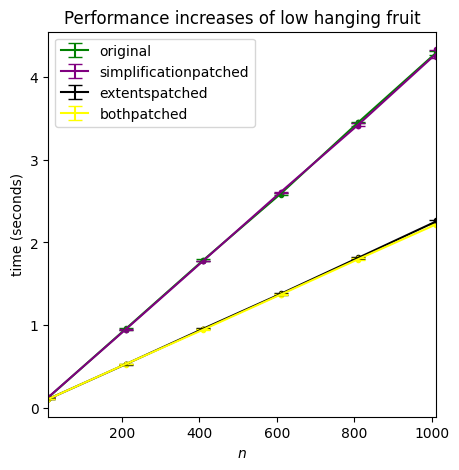

In [12]:

from statistics import mean, stdev
from matplotlib.markers import MarkerStyle
import matplotlib.pyplot as plt
from numpy import average
plt.subplots(1, 1, figsize=(5, 5))

plt.ylabel('time (seconds)')
for i, benchmark in enumerate(benchmark_configs):
  plt.subplot(1, 1, i+1)
  plt.xlim(benchmark['iterator'][0], benchmark['iterator'][-1])
  plt.title(benchmark['display']['title'])
  plt.xlabel(benchmark['display']['xlabel'])
  for label, time_result in benchmark_results[benchmark['name']].items():
    for i in benchmark['iterator']:
      plt.scatter([i]*NUM_REPEATS, time_result[i], c=label_to_colors[label], marker='.')
    plt.errorbar(benchmark['iterator'], [mean(time_result[i]) for i in benchmark['iterator']], yerr=[stdev(time_result[i]) for i in benchmark['iterator']], marker='', capsize=5.0, label=label, c=label_to_colors[label])

plt.legend()
plt.show()